# Sieć klasyfikacyjna (dla więcej niż 2 klas)
Dzieli dane na kilka typów (np.zdjęcia zwięrząt na gatunki: kot, pies, żaba, kurczak)

In [141]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 1. Przygotowanie danych

In [142]:
X, y  = make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=1.5)
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.long)

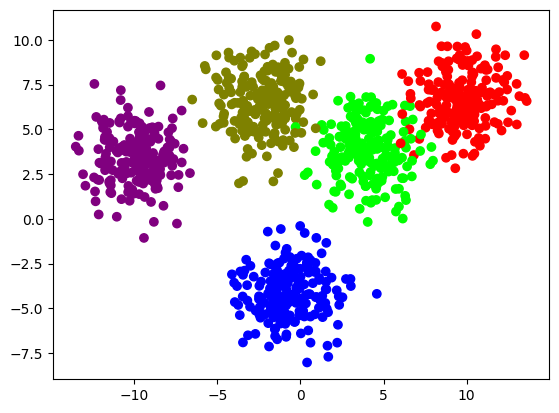

In [143]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')

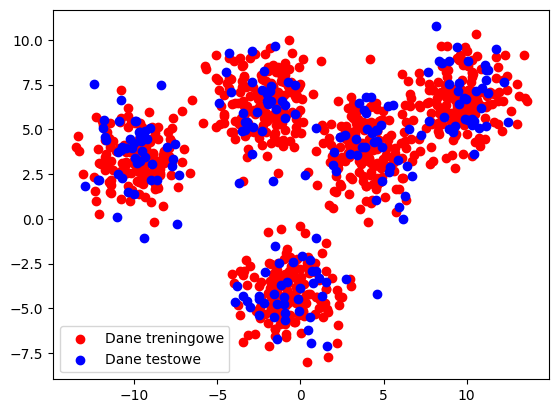

In [144]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train, x_test, y_train, y_test = x_train.to(device), x_test.to(device), y_train.to(device), y_test.to(device)
plt.scatter(x_train[:, 0], x_train[:,1], c='r', label='Dane treningowe')
plt.scatter(x_test[:, 0], x_test[:,1], c='b', label='Dane testowe')
plt.legend()

## 2. Model sieci neuronowej

In [145]:
class MultiClassClassification(nn.Module):
    #Warstwy sieci
    def __init__(self, input_features, output_features, hidden_size=32):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_features)
        )
        
    def forward(self, x):
        return self.layer_stack(x)
    
model = MultiClassClassification(input_features=2, output_features=5, hidden_size=128).to(device)

In [146]:
#Funkcja kosztu i optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
cost_func = nn.CrossEntropyLoss()

In [147]:
#Funkcja wyliczająca dokładność sieci
def accuracy(pred, target):
    return (torch.eq(pred, target).sum().item()/len(pred))*100

### Przewidywania przed trenowaniem

In [148]:
with torch.inference_mode():
    logits = model(X)
#Zmiana logitów na prawdopodobieństwa przewidywań
pred_probability = torch.softmax(logits, dim=1)
#Zamiana przwdobodobieńst przewidiywań na przewidywania
untrained_preds = torch.argmax(pred_probability, dim=1)

## 3. Pętla treningowa

In [149]:
epochs = 1000
for epoch in range(epochs):
    #___Training___
    #Wejście w tryb treningowy
    model.train()
    
    #1. Forward
    train_logits = model.forward(x_train)
    train_pred_probs = torch.softmax(train_logits, dim=1)
    train_preds = torch.argmax(train_pred_probs, dim=1)
    
    #2. Wyliczenie kosztu
    train_loss = cost_func(train_logits, y_train)
    train_acc = accuracy(train_preds, y_train)
    
    #3. Zero grad
    optimizer.zero_grad()
    
    #4. Backward
    train_loss.backward()
    
    #5. Optimizer step
    optimizer.step()
    
    #___Validation___
    model.eval()
    with torch.inference_mode():
        test_logits = model.forward(x_test)
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_preds = torch.argmax(test_pred_probs, dim=1)
        
        test_loss = cost_func(test_logits, y_test)
        test_acc = accuracy(test_preds, y_test)
        
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
        

Epoch: 0 | Train loss: 1.9084 | Train acc: 23.50% | Test Loss: 1.5112 | Test acc: 34.50
Epoch: 100 | Train loss: 0.0662 | Train acc: 97.88% | Test Loss: 0.0719 | Test acc: 97.50
Epoch: 200 | Train loss: 0.0328 | Train acc: 98.88% | Test Loss: 0.0403 | Test acc: 97.50
Epoch: 300 | Train loss: 0.0269 | Train acc: 99.00% | Test Loss: 0.0327 | Test acc: 98.00
Epoch: 400 | Train loss: 0.0247 | Train acc: 99.12% | Test Loss: 0.0290 | Test acc: 98.50
Epoch: 500 | Train loss: 0.0238 | Train acc: 99.12% | Test Loss: 0.0279 | Test acc: 98.50
Epoch: 600 | Train loss: 0.0233 | Train acc: 99.25% | Test Loss: 0.0276 | Test acc: 98.50
Epoch: 700 | Train loss: 0.0228 | Train acc: 99.25% | Test Loss: 0.0277 | Test acc: 98.50
Epoch: 800 | Train loss: 0.0224 | Train acc: 99.25% | Test Loss: 0.0279 | Test acc: 98.50
Epoch: 900 | Train loss: 0.0220 | Train acc: 99.25% | Test Loss: 0.0283 | Test acc: 98.50


### Przewidywania po trenowaniu

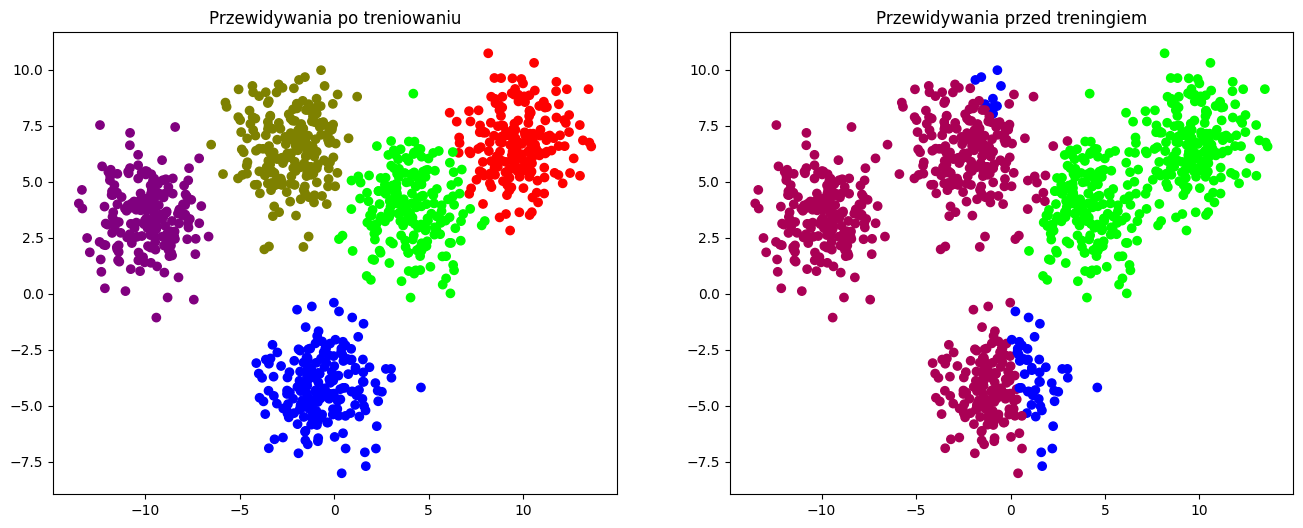

In [150]:
with torch.inference_mode():
    preds = torch.argmax(torch.softmax(model(X), dim=1),dim=1)
plt.figure(figsize=(16,  6))
plt.subplot(1, 2, 1)
plt.title("Przewidywania po treniowaniu")
plt.scatter(X[:, 0], X[:,1], c=preds, cmap='brg')
plt.subplot(1, 2, 2)
plt.title("Przewidywania przed treningiem")
plt.scatter(X[:, 0], X[:,1], c=untrained_preds, cmap='brg')

### Granica decyzyjna sieci

In [151]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("File already exists")
else:
    print("Downloading...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

File already exists


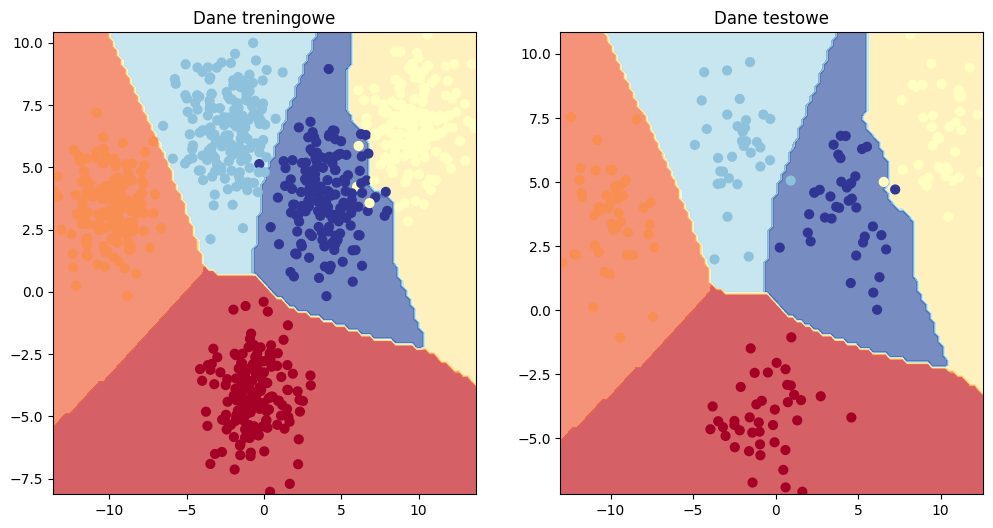

In [152]:
plt.figure(figsize=(12,  6))
plt.subplot(1, 2, 1)
plt.title("Dane treningowe")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Dane testowe")
plot_decision_boundary(model, x_test, y_test)

## 4. Zapisywanie modelu

In [153]:
MODEL_NAME = 'MulticlassClassificationModel.pt'
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [154]:
#Nowy model
model_load = MultiClassClassification(2, 5, hidden_size=128)

### Przewidywania przed wczytaniem

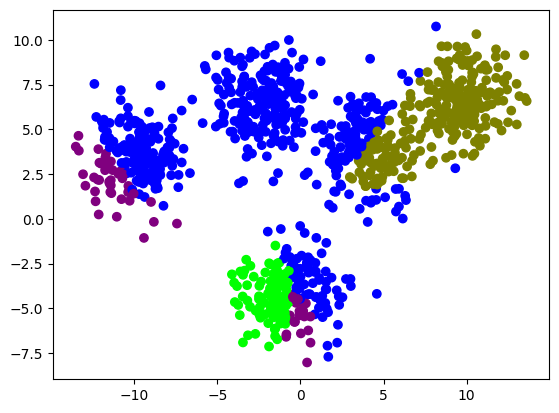

In [155]:
with torch.inference_mode():
    pre_load_preds = torch.argmax(torch.softmax(model_load(X), dim=1), dim=1)
plt.scatter(X[:,0], X[:,1], c=pre_load_preds, cmap='brg')

### Przewidywania po wczytaniu

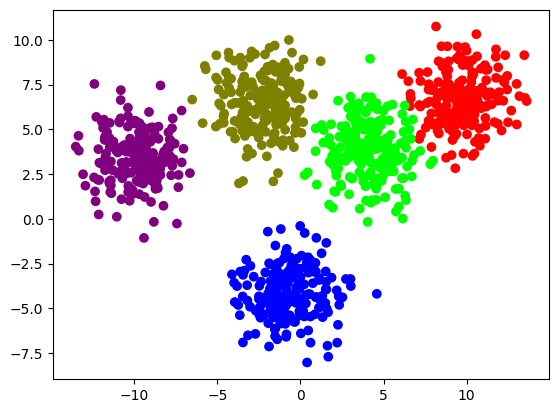

In [156]:
model_load.load_state_dict(torch.load(MODEL_SAVE_PATH))
with torch.inference_mode():
    pre_load_preds = torch.argmax(torch.softmax(model_load(X), dim=1), dim=1)
plt.scatter(X[:,0], X[:,1], c=pre_load_preds, cmap='brg')